In [1]:
import pandas as pd
import numpy as np
import csv
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D


   Gender Ever_Married Age Graduated     Profession Work_Experience  \
0    Male           No  22        No     Healthcare             1.0   
1  Female          Yes  38       Yes       Engineer                   
2  Female          Yes  67       Yes       Engineer             1.0   
3    Male          Yes  67       Yes         Lawyer             0.0   
4  Female          Yes  40       Yes  Entertainment                   

  Spending_Score Family_Size  Var_1 Segmentation  
0            Low         4.0  Cat_4            D  
1        Average         3.0  Cat_4            A  
2            Low         1.0  Cat_6            B  
3           High         2.0  Cat_6            B  
4           High         6.0  Cat_6            A  
Proportion of Missing Values in Dataset: 0.1960832920178483
We have retained 0.8261031234506693  of the original dataset after removing empty values


            Age  Work_Experience  Family_Size  Var_1_Cat_1  Var_1_Cat_2  \
PC_1  0.318420         0.050299     0.097

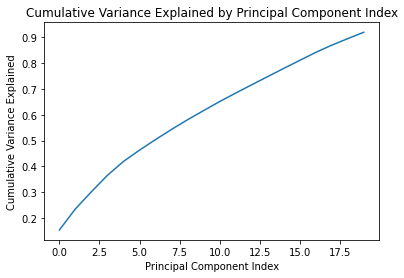

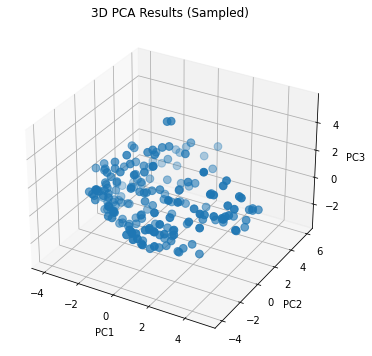

In [2]:
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, "Train.csv")
with open(file_path, mode='r') as csv_file:
    read = csv.reader(csv_file)
    matrix = [row for row in read]

training_data_raw = pd.DataFrame(matrix[1:], columns=matrix[0])

#training_data_raw = pd.read_csv("Train.csv")

training_data_raw.drop('ID', axis=1, inplace=True)
print(training_data_raw.head())
print("Proportion of Missing Values in Dataset:",(sum(training_data_raw["Gender"] == "")+sum(training_data_raw["Ever_Married"] == "")+sum(training_data_raw["Age"] == "")+sum(training_data_raw["Graduated"] == "")+sum(training_data_raw["Profession"] == "")+sum(training_data_raw["Work_Experience"] == "")+sum(training_data_raw["Spending_Score"] == "")+sum(training_data_raw["Family_Size"] == "")+sum(training_data_raw["Var_1"] == "")+sum(training_data_raw["Segmentation"] ==""))/(training_data_raw.shape[0]))
original_length = training_data_raw.shape[0]
#We will retain ~80% of the dataset and remove the rows where empty values exist


training_data_raw = (training_data_raw[~training_data_raw.eq("").any(axis=1)])
print("We have retained", training_data_raw.shape[0]/original_length, " of the original dataset after removing empty values")

X = pd.get_dummies(training_data_raw, columns=['Var_1', 'Spending_Score', 'Profession', 'Gender', 'Graduated', 'Ever_Married', 'Segmentation'])

imputer = SimpleImputer(strategy='most_frequent')
columns = X.columns
X[columns] = imputer.fit_transform(X[columns])


X = X.apply(pd.to_numeric)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca_20d = PCA(n_components = 20)
X_20d = pca_20d.fit_transform(X_scaled)
var_explained = pca_20d.explained_variance_ratio_
var_cumulative = np.cumsum(var_explained)
plt.plot(var_cumulative)
plt.title("Cumulative Variance Explained by Principal Component Index")
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Variance Explained")

pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_scaled)



dataset_pca = pd.DataFrame(abs(pca_3d.components_), columns=X.columns, index=['PC_1', 'PC_2', 'PC_3'])
print('\n\n', dataset_pca)

random_indices = np.random.choice(X_3d.shape[0], 200, replace=False)
X_3d_sample = X_3d[random_indices, :]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D PCA results with randomly selected points
ax.scatter(X_3d_sample[:, 0], X_3d_sample[:, 1], X_3d_sample[:, 2], s=60)

ax.set_xlim(X_3d_sample[:, 0].min() - 1, X_3d_sample[:, 0].max() + 1)
ax.set_ylim(X_3d_sample[:, 1].min() - 1, X_3d_sample[:, 1].max() + 1)
ax.set_zlim(X_3d_sample[:, 2].min() - 1, X_3d_sample[:, 2].max() + 1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Setting title
ax.set_title('3D PCA Results (Sampled)')

# Show plot
plt.show()


In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_3d)
    inertias.append(kmeans.inertia_)

for i, inertia in enumerate(inertias, 1):
    print(f"Inertia for {i} clusters: {inertia}")

    
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Update the optimal_num_clusters based on the elbow method result
optimal_num_clusters = 8
kmeans = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Predict cluster labels
# After fitting KMeans with the desired number of clusters
labels = kmeans.predict(X_scaled)

# Create a new figure for 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points with their respective clusters
scatter = ax.scatter(X_3d_sample[:, 0], X_3d_sample[:, 1], X_3d_sample[:, 2], c=labels[random_indices], cmap='viridis', s=60, alpha=0.6)

# Set axis limits to accommodate the range of sampled data points
ax.set_xlim(X_3d_sample[:, 0].min() - 1, X_3d_sample[:, 0].max() + 1)
ax.set_ylim(X_3d_sample[:, 1].min() - 1, X_3d_sample[:, 1].max() + 1)
ax.set_zlim(X_3d_sample[:, 2].min() - 1, X_3d_sample[:, 2].max() + 1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Setting title
ax.set_title(f'KMeans Clustering with {optimal_num_clusters} clusters')

# Show color bar legend for clusters
plt.colorbar(scatter, ax=ax, label='Clusters')

# Show plot
plt.show()

/Users/marcgodick/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


AttributeError: 'NoneType' object has no attribute 'split'